# 온라인 광고 클릭 예측 모델 만들기

### 1. 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np

In [2]:
train_df = pd.read_csv("train.csv", nrows = 2000)
train_df

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1000009418151094273,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,-1,79
1,10000169349117863715,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
2,10000371904215119486,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
3,10000640724480838376,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,100084,79
4,10000679056417042096,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,10285851261435514187,0,14102100,1005,0,97c9ac6a,5baa6f69,f66779e6,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157
1996,10285895913379867992,0,14102100,1005,0,85f751fd,c4e18dd6,50e219e0,d44c074c,ae637522,...,1,2,21611,320,50,2480,3,297,100111,61
1997,10286262651832627320,0,14102100,1005,0,85f751fd,c4e18dd6,50e219e0,53de0284,d9b5648e,...,1,0,21611,320,50,2480,3,297,100111,61
1998,1028628829893990987,0,14102100,1002,0,85f751fd,c4e18dd6,50e219e0,c73fb408,7801e8d9,...,0,0,17894,320,50,2039,2,39,100077,32


In [3]:
unused_columns = ["id", "hour", "device_id", "device_ip"]
label_column = "click"
train_df = train_df.drop(unused_columns, axis = 1)
X_dict_train = list(train_df.drop(label_column, axis =1).T.to_dict().values())
y_train = train_df[label_column]

In [4]:
test_df = pd.read_csv("train.csv",header =0, skiprows=(1,5000), nrows = 2000)
test_df = test_df.drop(unused_columns, axis =1)
X_dict_test = list(test_df.drop(label_column, axis =1).T.to_dict().values())
y_test = test_df[label_column]

In [5]:
#원 핫 인코딩 벡터 변환
from sklearn.feature_extraction import DictVectorizer
vectorizer = DictVectorizer(sparse=True)
X_train = vectorizer.fit_transform(X_dict_train)
print(X_train.shape)
X_test = vectorizer.transform(X_dict_test)
print(X_test.shape)


(2000, 992)
(2000, 992)


## 2-1. 모델 학습(Decision Tree)

In [6]:
#그리드 서치를 이용한 의사결정 트리 모델 학습
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(criterion="gini",min_samples_split=30)
decision_tree.fit(X_train, y_train)
decision_tree.get_params()


{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 30,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [7]:
from sklearn.model_selection import GridSearchCV
parameters = {"max_depth":[3,10,None]}
grid_search = GridSearchCV(decision_tree, parameters, n_jobs=-1, cv=3, scoring="roc_auc")
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
decision_tree_best = grid_search.best_estimator_


{'max_depth': 10}


In [8]:
#의사결정 트리 모댈의 성능측정: 정확도, 혼동행렬, ROC의 AUC
y_pred = decision_tree_best.predict(X_test)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

from sklearn.metrics import roc_auc_score, roc_curve
y_pred_proba = decision_tree_best.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

0.8565
[[1651   19]
 [ 268   62]]


## 2-2. 학습 모델 (RandomForest)

In [9]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(criterion="gini", random_state=48)
random_forest.fit(X_train, y_train)
random_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 48,
 'verbose': 0,
 'warm_start': False}

In [10]:
paramerters = {"max_depth":[3,10,None]}
grid_search = GridSearchCV(random_forest, 
                          parameters, n_jobs=-1,
                          cv =3,
                          scoring="roc_auc")
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
random_forest_best = grid_search.best_estimator_

{'max_depth': 10}


In [11]:
y_pred = random_forest_best.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

y_pred_proba = random_forest_best.predict_proba(X_test)[:,1]
fpr2,tpr2,_ =roc_curve(y_test, y_pred_proba)
auc2 = roc_auc_score(y_test, y_pred_proba)

0.838
[[1670    0]
 [ 324    6]]


## 2-3. 학습 모델(LogisticRegression)

In [12]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, y_train)
clf.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [18]:
parameters = {'C':[0.001,0.01,0.1,1.0,10], 'penalty':['l1','l2'], 'random_state':[156]}
grid_search = GridSearchCV(clf, parameters, n_jobs=-1, cv=3, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
clf_best = grid_search.best_estimator_

{'C': 1.0, 'penalty': 'l2', 'random_state': 156}


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.6203432         nan 0.62038668        nan 0.62020675
        nan 0.62720879        nan 0.62032643]
  warnings.warn(


In [19]:
y_pred = clf_best.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

y_pred_proba = clf_best.predict_proba(X_test)[:,1]
fpr3,tpr3,_ = roc_curve(y_test, y_pred_proba)
auc3 = roc_auc_score(y_test, y_pred_proba)

0.8335
[[1666    4]
 [ 329    1]]


## 2-4. 학습 모델 (Knn)

In [25]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [28]:
paramters = {"n_neighbors":[1,2,3,4,5]}
grid_search = GridSearchCV(knn, parameters, n_jobs=-1,
                          cv=3, scoring ="roc_auc")
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
knn_best = grid_search.best_estimator_

{'n_neighbors': 3}


In [31]:
y_pred = knn_best.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

y_pred_proba = knn_best.predict_proba(X_test)[:,1]
fpr4, tpr4,_ = roc_curve(y_test, y_pred_proba)
auc4 = roc_auc_score(y_test, y_pred_proba)

0.8645
[[1614   56]
 [ 215  115]]


## 3. 최종 결과

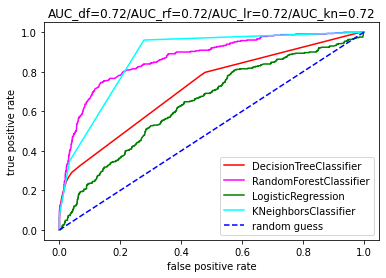

In [36]:
import matplotlib.pyplot as plt
plt.plot(fpr,tpr,"r-", label = "DecisionTreeClassifier")
plt.plot(fpr2,tpr2,"magenta", label = "RandomForestClassifier")
plt.plot(fpr3,tpr3,"green", label = "LogisticRegression")
plt.plot(fpr4, tpr4, "aqua", label = "KNeighborsClassifier")
plt.plot([0,1],[0,1], "b--", label = "random guess")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("AUC_df={0:.2f}/AUC_rf={0:.2f}/AUC_lr={0:.2f}/AUC_kn={0:.2f}".format(auc,auc2,auc3,auc4))
plt.legend(loc="lower right")